In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
train_dataset = MNIST(True)
test_dataset = MNIST(False)

In [4]:
train_x, train_y = train_dataset.data.numpy(), train_dataset.targets
test_x, test_y = test_dataset.data.numpy(), test_dataset.targets
train_y2 = to_one_hot(train_y, 10).numpy()
test_y2 = to_one_hot(test_y, 10).numpy()
train_y = train_y.numpy()
test_y = test_y.numpy()

In [5]:
train_data = FromNumpy(train_x[:, None, :, :], [train_y2, train_y], batch_size=256)
test_data = FromNumpy(test_x[:, None, :, :], [test_y2, test_y], batch_size=256)

In [6]:
class Orthogonal(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, w1, w2):
        return self.alpha * torch.matmul(w1, w2.t()).abs().mean()

In [65]:
"""

Implementation of the spectral normalization for the weight matrix

"""

import torch
import torch.nn as nn
from torch.nn import Parameter


class SpectralNorm(nn.Module):

    def __init__(self, module, name_module='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module= module
        self.name = name_module
        self.power_iter = power_iterations

        if not self._made_params():
            self._make_params()


    def update_u_v(self):
        """
        Updating the parameters u and v which would be used for the
        calculation of the spectral norm.
        :return:
        """

        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iter):
            v.data = self.l2normalize(torch.mv(torch.t(w.view(height, -1).data), u.data))
            u.data = self.l2normalize(torch.mv(w.view(height, -1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))

        setattr(self.module, self.name, w / sigma.expand_as(w))


    def l2normalize(self, v, eps=1e-12):
        return v / (v.norm() + eps)

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = self.l2normalize(u.data)
        v.data = self.l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]
        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self.update_u_v()
        return self.module.forward(*args)

In [96]:
model = builder([
    SpectralNorm(nn.Conv2d(1, 20, 5, 1), power_iterations=5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    SpectralNorm(nn.Conv2d(20, 50, 5, 1), power_iterations=5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    Flatten(),
    Auxiliary(builder([
        Reg(NoisyLinear(4*4*50, 128), 'orth'),
        nn.ReLU(),
        Reg(NoisyLinear(128, 10), 'orth2'),
        nn.Sigmoid()
    ])),
    Reg(NoisyLinear(4*4*50, 128), 'orth'),
    nn.ReLU(),
    Reg(NoisyLinear(128, 10), 'orth2'),
    nn.LogSoftmax(1)
])

In [97]:
runner = Runner(model, train_data, test_data, 'adam', ['bce', 'nll'], reg_fn={'orth': Orthogonal(), 'orth2': Orthogonal()}, fp16=False)

In [98]:
runner.fit(3, cycle='sc')

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        3.1230        0.6492        0.2978        0.9381    


    2         0.3748        0.9141        0.1534        0.9640    


    3         0.2433        0.9429        0.1170        0.9728    


In [ ]:
runner.fit(5, cycle='cycle')

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1         0.1801        0.9574        0.0956        0.9771    


    2         0.1459        0.9658        0.0866        0.9773    


    3         0.1197        0.9724        0.0778        0.9799    


    4         0.1080        0.9745        0.0700        0.9815    


    5         0.0939        0.9785        0.0645        0.9829    


    6         0.0838        0.9805        0.0620        0.9828    


In [75]:
runner.validate()

0.03543465777474921 0.9908


In [87]:
model = runner.model

tensor(9.)
tensor([[3.8736e-03, 5.1937e-05, 9.9325e-01, 7.0427e-04, 7.2974e-04, 1.4679e-06,
         5.5171e-06, 1.2599e-04, 1.1404e-03, 1.1737e-04]], device='cuda:0',
       grad_fn=<ExpBackward>)
tensor([[2.7269e-02, 2.7185e-04, 1.2167e-01, 5.7229e-03, 1.0014e-02, 7.0295e-05,
         4.2873e-05, 7.7518e-06, 9.8918e-05, 1.4215e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[1.0563e-04, 1.4119e-08, 1.2085e-01, 4.0304e-06, 7.3078e-06, 1.0319e-10,
         2.3653e-10, 9.7665e-10, 1.1281e-07, 1.6684e-05]], device='cuda:0',
       grad_fn=<MulBackward0>)


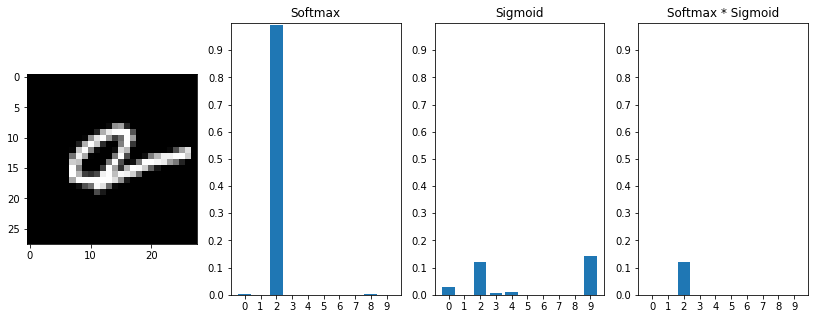

In [89]:
data = next(iter(test_data))
x = data[0][0]
x = x[None, :, :, :]
print(data[2][0])

x = x.permute(0,1,3,2)

out1 = model(x.cuda()).exp()
out2 = get_aux_out(model)[0]
print(out1)
print(out2)
print((out1*out2))

import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 4, figsize=(14, 5))
arr[0].imshow(x.numpy()[0][0], cmap='gray')
arr[1].set_title('Softmax')
arr[1].set_xticks(range(10))
arr[1].set_yticks([i/10 for i in range(10)])
arr[1].set_ylim(0, 1)
arr[1].bar(range(10), out1.detach().cpu().numpy()[0])
arr[2].set_title('Sigmoid')
arr[2].set_xticks(range(10))
arr[2].set_yticks([i/10 for i in range(10)])
arr[2].set_ylim(0, 1)
arr[2].bar(range(10), out2.detach().cpu().numpy()[0])
arr[3].set_title('Softmax * Sigmoid')
arr[3].set_xticks(range(10))
arr[3].set_yticks([i/10 for i in range(10)])
arr[3].set_ylim(0, 1)
arr[3].bar(range(10), ((out1*out2)).detach().cpu().numpy()[0])
plt.show()
